In [637]:
import zipfile
import pandas as pd
import os
import geopandas as gp
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import whiten
import numpy as np
import datetime
import pylab as pl
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [638]:
dataDir = '/Users/michelleho/PUI2015_mmh555/HW10/DATA'
dfs = {}
for subdir, dirs, files in os.walk(dataDir):
    for file in files[1:]:
        zf = zipfile.ZipFile(dataDir+'/'+file)
        dfs['{}'.format(os.path.splitext(file)[0][3:5]+'DF')] = pd.read_csv(zf.open(file.replace('.zip','.txt')))

In [639]:
for x in dfs.keys():
    try:
        dfs['{}'.format(x)] = dfs['{}'.format(x)][['ZIP','EST']]
        dfs['{}'.format(x)].rename(columns={'EST': '{}'.format(x[0:2])}, inplace=True)

    except KeyError:
            dfs['{}'.format(x)] = dfs['{}'.format(x)][['zip','est']]
            dfs['{}'.format(x)].rename(columns={'zip': 'ZIP', 'est': '{}'.format(x[0:2])}, inplace=True)
    #print dfs['{}'.format(x)].columns

In [640]:
dfMergeExample = pd.merge(dfs['02DF'], dfs['03DF'], on='ZIP', how = 'inner')

In [641]:
#Putting dataframes into List in order to reduce, not sure why but now it works!
dfsList = []
for x in dfs.keys():
    dfsList.append(dfs['{}'.format(x)])

In [642]:
len(dfsList)
#I am missing 2000 and 2001 data, therefore we have 18 datasets, not 20.

18

In [643]:
df_final = reduce(lambda left, right: pd.merge(left, right, on='ZIP', how = 'inner'), dfsList)

In [644]:
shapeData = gp.read_file('NYCzipcodeshapefile2.geojson')

In [645]:
shapeData.rename(columns = {'postalCode':'ZIP'}, inplace=True)

In [646]:
#Making sure the ZIP is a float in the shapeData, so we can join it with the establishment data
shapeData['ZIP'] = shapeData['ZIP'].astype(float)
print type(shapeData['ZIP'][0])

<type 'numpy.float64'>


In [647]:
myData_merged = pd.merge(df_final, shapeData, on = 'ZIP', how = 'inner')
myData = myData_merged[myData_merged.columns[1:19]] #removed the column of ZIP codes, maybe consider setting as index later
print type(myData)
zips = myData_merged['ZIP']

<class 'pandas.core.frame.DataFrame'>


In [648]:
#Renaming column headers to full year
for x in myData:
    myData.rename(columns = {'{}'.format(x):datetime.datetime.strptime('{}'.format(x), "%y").year}, inplace=True)

In [649]:
#Sorting dataframe by column header to get time series
myData = myData.reindex_axis(sorted(myData.columns),axis=1)
myData.head()

,1994,1995,1996,1997,1998,1999,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,6999,7088,7075,7154,7254,7233,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
1,1784,1819,1919,2049,2003,2085,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
2,3256,3377,3417,3535,3649,3659,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
3,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
4,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479


In [650]:
print np.asarray(myData.loc[0])
print len(myData)

[6999 7088 7075 7154 7254 7233 7141 7084 7370 7312 7415 7549 7472 7305 7241
 7227 7235 7273]
243


In [651]:
#Normalize across the time series
for i in range(len(myData)):
    zipMean = myData.loc[i].mean()
    zipSTD = myData.loc[i].std()
    myData.loc[i] = (np.asarray(myData.loc[i]) - zipMean)/zipSTD

In [652]:
#Sanity check: means should be near zero and standard deviations near one.
# for i in range(len(myData)):
#     print myData.loc[i].mean()
#     print myData.loc[i].std()

Nzipcodes = myData.shape[0]
Ntimestamps = myData.shape[1]
print "Number of zip codes: ", Nzipcodes
print "Number of time stamps: ", Ntimestamps

Number of zip codes:  243
Number of time stamps:  18


In [653]:
type(np.asarray(myData))

numpy.ndarray

In [654]:
nk= 5
cluster_centroids, closest_centroids = kmeans2(np.asarray(myData), 5, iter=15, minit = 'points')

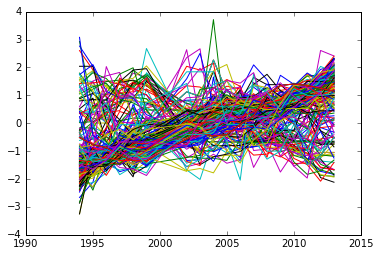

In [655]:
#Plotting all the time series together
for i in range(len(myData)):
    pl.plot(myData.loc[i])

In [656]:
print cluster_centroids.shape
#
dates = [1994, 1995, 1996, 1997, 1998, 1999, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
#print(dates)
cluster_centroidsDF = pd.DataFrame(cluster_centroids, columns = dates)

(5, 18)


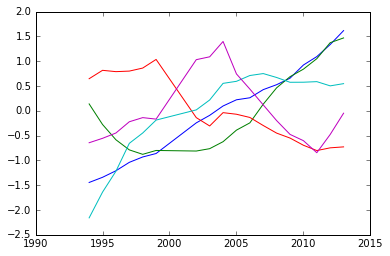

In [657]:
for i in range(0,5):
    pl.plot(cluster_centroidsDF.loc[i])

In [658]:
cluster_myData = myData.join(pd.Series(closest_centroids, name = 'Cluster Number'))

In [659]:
cluster_myData.head()

,1994,1995,1996,1997,1998,1999,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Cluster Number
0,-1.703900,-1.089806,-1.179505,-0.634410,0.055583,-0.089316,-0.724109,-1.117406,0.855975,0.455779,1.166472,2.091063,1.559768,0.407479,-0.034116,-0.130715,-0.075516,0.186681,3
1,-1.608752,-1.524391,-1.283359,-0.970018,-1.080893,-0.883247,-0.439749,-0.119177,0.239960,0.555712,0.565353,0.562943,0.577404,0.779871,1.013672,1.110084,1.211317,1.293268,0
2,-1.814413,-1.424651,-1.295805,-0.915707,-0.548493,-0.516282,-0.654792,-0.371329,-0.139405,0.153721,0.289010,0.739974,0.810840,0.901032,0.946129,1.094303,1.271467,1.474401,0
3,-1.502790,-1.424029,-1.345267,-0.995216,-0.968962,-0.470138,-0.295113,-0.303864,-0.032574,-0.233854,0.212462,0.728788,0.781295,0.807549,0.973824,1.026331,1.358880,1.682678,0
4,-1.502790,-1.424029,-1.345267,-0.995216,-0.968962,-0.470138,-0.295113,-0.303864,-0.032574,-0.233854,0.212462,0.728788,0.781295,0.807549,0.973824,1.026331,1.358880,1.682678,0


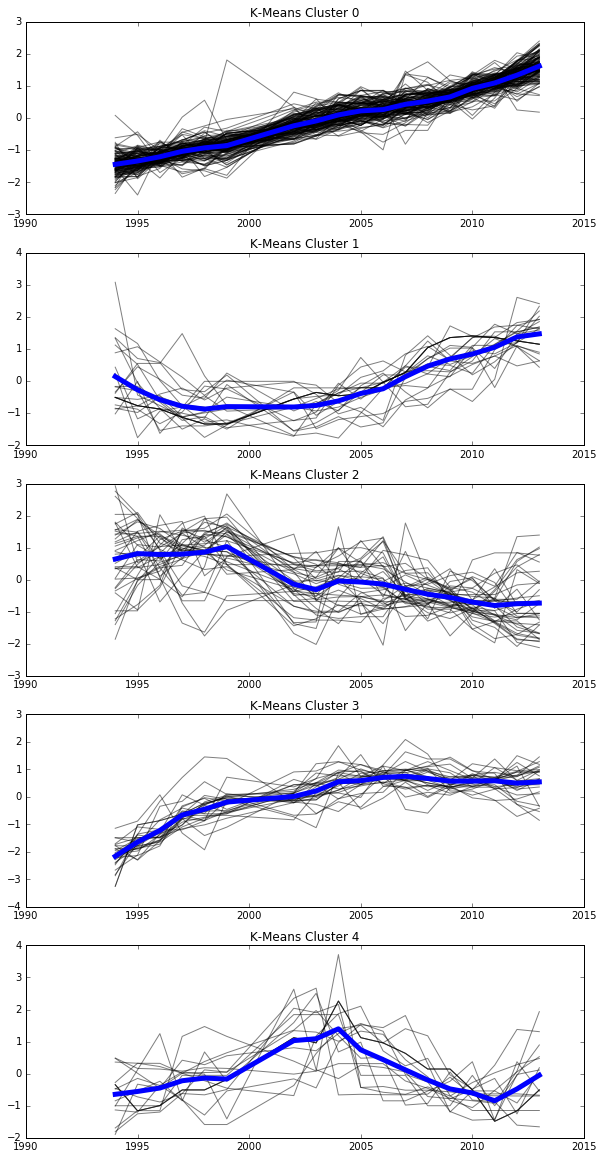

In [660]:
fig = pl.figure(figsize=(10,20))
ax = []
for i in range(0,5):
    ax.append(fig.add_subplot(5,1,i+1))
for i in range(len(myData)):
    cluster = int(cluster_myData.loc[i,'Cluster Number'])
    ax[cluster].plot(cluster_myData.loc[i,dates],'k', alpha = 0.5)
for i in range(0,5):
    ax[i].plot(cluster_centroidsDF.loc[i], linewidth=5)
    ax[i].set_title('K-Means Cluster {}'.format(i))

In [661]:
db = DBSCAN(eps=.9, min_samples=2).fit(myData)
labels = (db.labels_).astype(int)
print labels
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#clusters = pd.Series([myData[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

[-1  0  0  0  0  0  0 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0  0  0 -1  0  0  0  0  0  0  0  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0  0  0  0
  0  0  0 -1 -1  0 -1  0  0  0  0  0  0 -1  0  0 -1 -1  0  0  1  1  1 -1 -1
 -1 -1  0 -1 -1  0 -1 -1  0 -1 -1 -1 -1  2  2 -1  0  0  0  0  0  0 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0 -1  0  0 -1  0  0  0 -1  0 -1 -1  0  0 -1  0  0 -1  0  0  0
  3  3 -1  0  0  0 -1  0  0  0  0 -1  0  0 -1  0 -1 -1 -1  0  0  0 -1  0 -1
  0 -1 -1 -1  0 -1  0  0  0 -1  0 -1  4  4  4  4 -1 -1]
Number of clusters: 5


In [662]:
cluster_myData2 = myData.join(pd.Series(labels, name = 'DBSCAN Cluster Number'))

In [663]:
cluster_myData2['DBSCAN Cluster Number'] = cluster_myData2['DBSCAN Cluster Number']+1
#print cluster_myData2.head()
#print labels

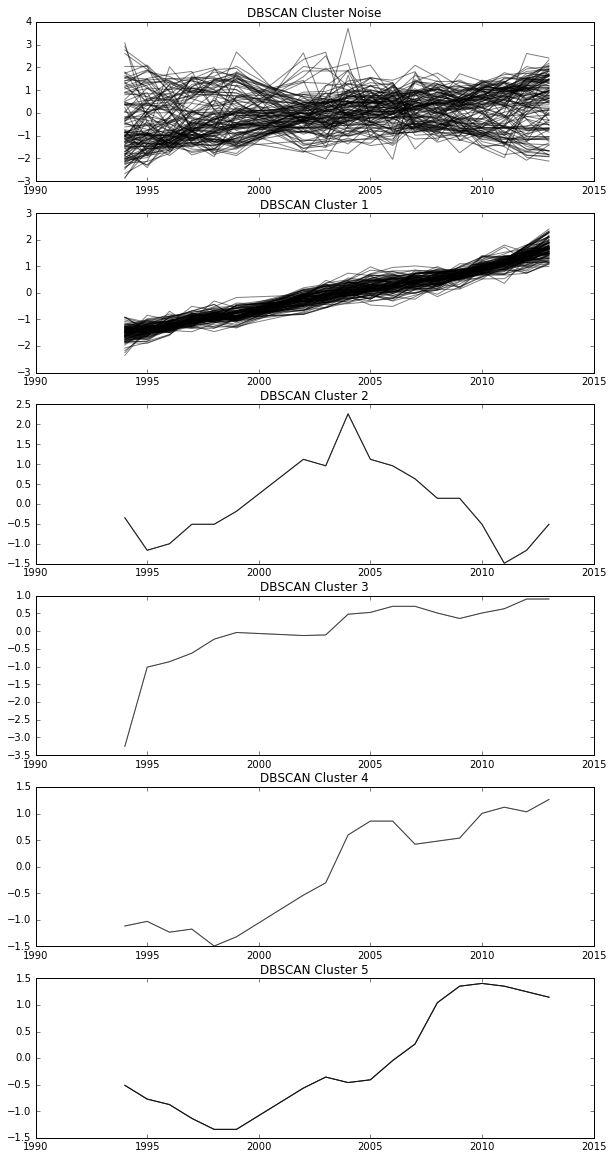

In [664]:
fig = pl.figure(figsize=(10,20))
ax = []
for i in range(0,6):
    ax.append(fig.add_subplot(6,1,i+1))
for i in range(len(cluster_myData2)):
    cluster = int(cluster_myData2.loc[i,'DBSCAN Cluster Number'])
    ax[cluster].plot(cluster_myData2.loc[i,dates],'k', alpha = 0.5)
for i in range(1,6):
    #ax[i].plot(cluster_centroidsDF.loc[i], linewidth=5)
    ax[i].set_title('DBSCAN Cluster {}'.format(i))
ax[0].set_title('DBSCAN Cluster Noise')

#Plot on map

In [665]:
myData_merged = pd.merge(df_final, shapeData, on = 'ZIP', how = 'inner')
plotKmeans = myData_merged.join(pd.Series(closest_centroids, name = 'Cluster Number'))
plotKmeans.columns

Index([           u'ZIP',             u'06',             u'05',
                   u'02',             u'03',             u'99',
                   u'94',             u'13',             u'07',
                   u'97',             u'10',             u'98',
                   u'08',             u'12',             u'95',
                   u'11',             u'04',             u'96',
                   u'09',            u'@id', u'BLDGpostalCode',
             u'CTY_FIPS',       u'OBJECTID',        u'PO_NAME',
                u'STATE',        u'ST_FIPS',     u'Shape_Area',
           u'Shape_Leng',        u'borough',       u'geometry',
       u'Cluster Number'],
      dtype='object')

In [666]:
# fig = plt.figure()
# polygon = shapeData['geometry'][29]
# print polygon
# ax = fig.gca()
# sample_patch = PolygonPatch(polygon)
# ax.add_patch(sample_patch)
# ax.axis('scaled')

In [667]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

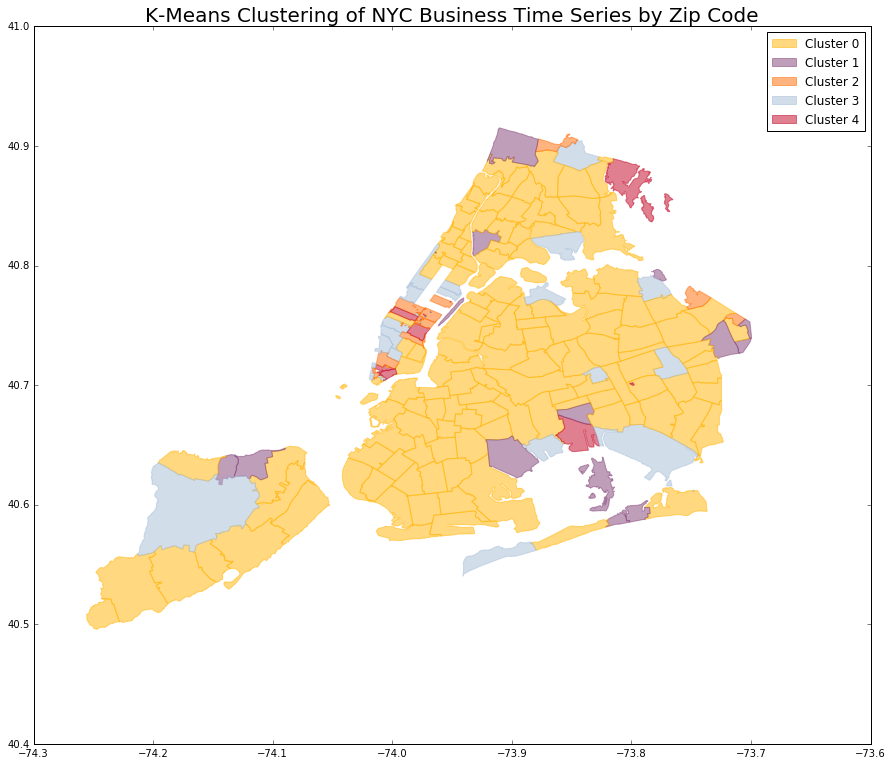

In [668]:
fig = plt.figure(figsize=(15,15))

for i in range(len(plotKmeans)):
    poly = plotKmeans['geometry'][i]
    postcode = plotKmeans['ZIP'][i]
    cluster = plotKmeans['Cluster Number'][i]
    ax = fig.gca()
    color = kelly_colors_hex[cluster]
    ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5))
ax.axis('scaled')
ax.set_title('K-Means Clustering of NYC Business Time Series by Zip Code', size=20)

import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')

handles = []
for i in set(closest_centroids):
    patch = mpatches.Patch(color=kelly_colors_hex[i], alpha=0.5, label='Cluster {}'.format(i))
    handles.append(patch)
ax.legend(handles=handles,loc='best')

In [669]:
plotDBSCAN = myData_merged.join(pd.Series(labels, name = 'DBScan Cluster'))

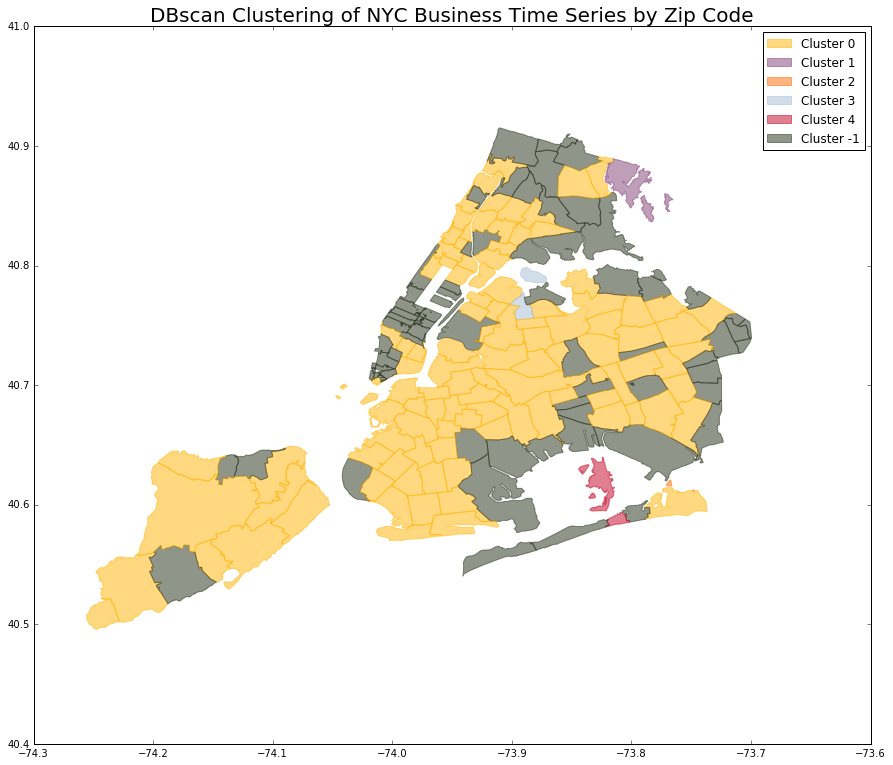

In [670]:
fig = plt.figure(figsize=(15,15))

for i in range(len(plotDBSCAN)):
    poly = plotDBSCAN['geometry'][i]
    postcode = plotDBSCAN['ZIP'][i]
    cluster = plotDBSCAN['DBScan Cluster'][i]
    ax = fig.gca()
    color = kelly_colors_hex[cluster]
    ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5))
ax.axis('scaled')
ax.set_title('DBscan Clustering of NYC Business Time Series by Zip Code', size=20)

import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')

handles = []
for i in set(labels):
    patch = mpatches.Patch(color=kelly_colors_hex[i], alpha=0.5, label='Cluster {}'.format(i))
    handles.append(patch)
ax.legend(handles=handles,loc='best')

##Conclusion:

K-means clustering captures upward growth zip codes very well (cluster 0). Visually, it captures the trends of other zip codes fairly well. My density based clustering method captures zip codes that grow, but otherwise designated a lot of other zip codes as "noise" (cluster -1). This makes intuitive sense since this is a density-based method. Looking at the cluster time series graphs for K-means, we see that all other clusters look far less dense than cluster 0. If we play with the parameters of the DBSCAN method, for example by expanding the eps parameter, we might be able to bring some of the "noise" zip codes into clusters.

Otherwise, for the most part, most zip codes in NYC experienced business expansion from 1994 to 2013.